In [31]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
from heapq import nsmallest
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft, ifft
from scipy import integrate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import CubicSpline , interp1d


import logging

In [33]:
#Lecture data: lines klaus, cromospheric spectrum, VALD
#c_lines_spectrum =  pd.read_csv("absortionlines.csv", delimiter = ',', header = 0)
#clines = pd.read_csv("c_lines_spectrum.txt", delimiter = '\t', header = 0)
theoric_lines = pd.read_csv('DataSet/Inputs/theoric_c_lines.txt', delimiter = '\t', header = 0)
#theoric_lines =  pd.read_excel("lines.xlsx",sheet_name="cromospheric_lines", columns = ['waveobs','wave_base', 'wave_top','element'] )
theoric_lines['wave_peak'] = theoric_lines['wave_peak']/10
theoric_lines['wave_base'] = theoric_lines['wave_base']/10
theoric_lines['wave_top'] = theoric_lines['wave_top']/10
c_s = pd.read_csv('DataSet/Inputs/Subtracted_spectrum.txt', delimiter = '\t', header = 0)

data_klaus = pd.read_csv("DataSet/Inputs/Ti2_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1'], header = 0)

growth_c_ispec_gauss = pd.read_csv("DataSet/Outputs/Ti2_substract_ispec_gauss.dat", delimiter = '\t', usecols = ['wave_nm', 'wave_base', 'wave_top','loggf', 'ewr'], header = 0)
growth_c_ispec_voigth = pd.read_csv("DataSet/Outputs/Ti2_substract_ispec_voigth.dat", delimiter = '\t', usecols = ['wave_nm', 'wave_base', 'wave_top','loggf', 'ewr'], header = 0)

growth_c_mine = pd.read_csv("DataSet/Outputs/Ti 2_growth_curve.dat", delimiter = '\t', header = 0)
Atomic_lines = pd.read_csv('DataSet/Inputs/atomic_lines.tsv', delimiter = '\t', usecols = ['element', 'wave_nm', 'loggf', 'lower_state_eV', 'upper_state_eV'],   header = 0, low_memory=False, keep_default_na= False)
Atomic_lines = Atomic_lines[(Atomic_lines['wave_nm']>=375) & (Atomic_lines['wave_nm']<=465)]

In [14]:
peak = []
for i in range(len(theoric_lines['wave_peak'])):
    peak.append(nsmallest(1,Atomic_lines['wave_nm'], key = lambda x: abs(x-theoric_lines['wave_peak'][i]))[0])

In [26]:
Atomic_lines1 = []
for i in range(len(peak)):
    Atomic_lines1.append(Atomic_lines[(Atomic_lines['wave_nm'] == peak[i])])

106

In [70]:
print(Atomic_lines1[0]['wave_nm'].values[0])

376.1321


In [88]:
Atomic_lines1[0]['lower_state_eV'].values[0]

0.574

In [85]:
lista = [2,4,6,8]
match_atomic_theoric = pd.DataFrame(columns = ['wave_peak', 'wave_base', 'wave_top','note', 'loggf', 'lower_state_eV', 'upper_state_eV'])
match_atomic_theoric['wave_base'] = theoric_lines['wave_base']
match_atomic_theoric['wave_top'] = theoric_lines['wave_top']

for i in range(len(Atomic_lines1)):
    match_atomic_theoric['wave_peak'].loc[i] = Atomic_lines1[i]['wave_nm'].values[0]
    match_atomic_theoric['note'].loc[i] = Atomic_lines1[i]['element'].values[0]
    match_atomic_theoric['loggf'].loc[i] = Atomic_lines1[i]['loggf'].values[0]
    match_atomic_theoric['lower_state_eV'].loc[i] = Atomic_lines1[i]['lower_state_eV'].values[0]
    match_atomic_theoric['upper_state_eV'].loc[i] = Atomic_lines1[i]['upper_state_eV'].values[0]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [86]:
match_atomic_theoric['wave_peak']

0      376.132
1      376.379
2      376.719
3      376.946
4      377.063
        ...   
101    456.376
102    457.197
103    458.383
104    458.996
105    462.934
Name: wave_peak, Length: 106, dtype: object

In [87]:
match_atomic_theoric

,wave_peak,wave_base,wave_top,note,loggf,lower_state_eV,upper_state_eV
0,376.132,376.075,376.210,Ti 2,0.18,0.574,3.869
1,376.379,376.340,376.434,Fe 1,-0.238,0.99,4.283
2,376.719,376.670,376.755,Fe 1,-0.389,1.011,4.301
3,376.946,376.941,376.951,Ni 2,-1.716,3.104,6.392
4,377.063,377.058,377.068,H 1,-1.644,10.199,13.486
...,...,...,...,...,...,...,...
101,456.376,456.348,456.432,Ti 2,-0.69,1.221,3.937
102,457.197,457.147,457.248,Ti 2,-0.31,1.572,4.283
103,458.383,458.303,458.444,Fe 2,-1.86,2.807,5.511
104,458.996,458.962,459.028,Cr 2,-4.496,3.105,5.805


## Found absortion lines

In [77]:
top = []
for i in range(len(theoric_lines['wave_top'])):
    top.append(nsmallest(1,c_s['waveobs'], key = lambda x: abs(x-theoric_lines['wave_top'][i]))[0])

In [78]:
base = []
for i in range(len(theoric_lines['wave_base'])):
    base.append(nsmallest(1,c_s['waveobs'], key = lambda x: abs(x-theoric_lines['wave_base'][i]))[0])

In [81]:
#Create new list with contain the absortion lines in cromospheric spectrum with its respective element
c_lines_spectrum = pd.DataFrame(columns = ['wave_peak', 'wave_base', 'wave_top','note', 'flux', 'error_f'])
L = []
I = []
mins = []
       
for i in range(len(base)):
    b = c_s['waveobs']>base[i]
    a = c_s['waveobs']<top[i]
    c = a&b 
    min_ = min(c_s['flux'][c])
    L.append(c_s["waveobs"][c][c_s["flux"][c] == min_].tolist()[0])
    I.append(c_s['flux'][c][c_s["flux"][c] == min_].tolist()[0])
    mins.append(min_)
    
c_lines_spectrum['wave_peak'] = L
c_lines_spectrum['wave_base'] = base
c_lines_spectrum['wave_top'] = top
c_lines_spectrum['note'] = theoric_lines['note']
c_lines_spectrum['flux'] = I
c_lines_spectrum['error_f'] = c_s['err']

In [83]:
c_lines_spectrum.to_csv("c_lines_spectrum.txt", sep='\t', index = False, header=True)

In [82]:
c_lines_spectrum

,wave_peak,wave_base,wave_top,note,flux,error_f
0,376.141,376.075,376.210,Ti 2,-0.031778,0.043839
1,376.385,376.340,376.434,Fe 1,0.111095,0.044753
2,376.726,376.670,376.755,Fe 1,0.178483,0.045666
3,376.942,376.941,376.951,Ni 2,0.414191,0.044197
4,377.067,377.058,377.068,H 1,-0.018008,0.042653
...,...,...,...,...,...,...
101,456.378,456.348,456.432,Ti 2,0.189061,0.048734
102,457.202,457.147,457.248,Ti 2,0.161474,0.050448
103,458.391,458.303,458.444,Fe 2,0.229323,0.052161
104,458.996,458.962,459.028,Ti 2,0.521219,0.053875


In [35]:
data_element = c_lines_spectrum[c_lines_spectrum['element'] == 'Ti 2']
data_element.index = list(range(len(data_element)))
data_element

,waveobs,wave_base,wave_top,element,flux,error_f
0,376.141,376.075,376.210,Ti 2,-0.031778,0.043839
1,378.801,378.758,378.821,Ti 2,0.487668,0.038036
2,382.041,381.998,382.102,Ti 2,0.062097,0.031372
3,382.455,382.405,382.491,Ti 2,0.325723,0.030359
4,391.357,391.302,391.398,Ti 2,0.088786,0.037501
5,393.370,393.361,393.371,Ti 2,0.023726,0.042899
6,394.525,394.516,394.526,Ti 2,1.241088,0.046374
7,399.902,399.893,399.903,Ti 2,0.977744,0.049144
8,417.757,417.749,417.759,Ti 2,0.647348,0.047001
9,422.677,422.668,422.678,Ti 2,0.019586,0.051112


In [39]:
#Separate by elements
Fe1__ = theoric_lines[theoric_lines['element']=='Fe 1']
Ti2__ = theoric_lines[theoric_lines['element']=='Ti 2']
Fe2__ = theoric_lines[theoric_lines['element']=='Fe 2']

Fe1__.index = list(range(len(Fe1__)))
Ti2__.index = list(range(len(Ti2__)))
Fe2__.index = list(range(len(Fe2__)))

Ti2__

,waveobs,wave_base,wave_top,element
0,376.132,376.075,376.210,Ti 2
1,378.788,378.758,378.821,Ti 2
2,382.043,381.998,382.102,Ti 2
3,382.445,382.405,382.491,Ti 2
4,391.346,391.302,391.398,Ti 2
5,393.366,393.361,393.371,Ti 2
6,394.521,394.516,394.526,Ti 2
7,399.898,399.893,399.903,Ti 2
8,417.754,417.749,417.759,Ti 2
9,422.673,422.668,422.678,Ti 2


## Associate atomic data

In [41]:
_Fe1 = lines_s[lines_s['element']=='Fe 1']
_Ti2 = lines_s[lines_s['element']=='Ti 2']
_Fe2 = lines_s[lines_s['element']=='Fe 2']

_Fe1.index = list(range(len(_Fe1)))
_Ti2.index = list(range(len(_Ti2)))
_Fe2.index = list(range(len(_Fe2)))

In [42]:
#Separate by elements the atomic lines for decrease the amount of data
Fe1_ = Atomic_lines[Atomic_lines['element']=='Fe 1']
Fe2_ = Atomic_lines[Atomic_lines['element']=='Fe 2']
Ti2_ = Atomic_lines[Atomic_lines['element']=='Ti 2']

#Use just workin data range
Fe1_VALD = Fe1_[(Fe1_['wave_A'] >= 3760) & (Fe1_['wave_A'] <= 4420)]
Fe1_VALD.index = list(range(len(Fe1_VALD)))
Fe2_VALD = Fe2_[(Fe2_['wave_A'] >= 3760) & (Fe2_['wave_A'] <= 4590)]
Fe2_VALD.index = list(range(len(Fe2_VALD)))
Ti2_VALD = Ti2_[(Ti2_['wave_A'] >= 3760) & (Ti2_['wave_A'] <= 4590)]
Ti2_VALD.index = list(range(len(Ti2_VALD)))

#Working in nm
Fe1_VALD['wave_A'] = Fe1_VALD['wave_A']/10
Fe2_VALD['wave_A'] = Fe2_VALD['wave_A']/10
Ti2_VALD['wave_A'] = Ti2_VALD['wave_A']/10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [46]:
Ti2_VALD[93:110]

,element,wave_A,loggf
93,Ti 2,393.1680,-5.761
94,Ti 2,393.2009,-1.590
95,Ti 2,393.2161,-5.290
96,Ti 2,393.3763,-4.720
97,Ti 2,393.3990,-6.264
98,Ti 2,393.4384,-3.044
99,Ti 2,393.5594,-5.141
100,Ti 2,393.6306,-6.612
101,Ti 2,393.7812,-1.010
102,Ti 2,393.8141,-1.200


In [36]:
new_listgf = []
loggf = []
for i in range(len(Ti2['waveobs'])):
    x = abs(nsmallest(1,Ti2_VALD['wave_A'], key = lambda x: abs(x-Ti2['waveobs'][i]))[0] - Ti2['waveobs'][i])
    if x < 0.05:
        new_listgf.append(nsmallest(1,Ti2_VALD['wave_A'], key = lambda x: abs(x-Ti2['waveobs'][i]))[0])
        print(len(new_listgf))
        loggf.append(Ti2_VALD[Ti2_VALD["wave_A"] == new_listgf[i]]["loggf"].tolist()[0])

NameError: name 'Ti2' is not defined

# Base and top

In [105]:
Ti2_gf = pd.DataFrame(columns = ['waveobs','element', 'flux', 'loggf', 'wave_base', 'wave_top', 'error_f'])
Ti2_gf['waveobs'] = Ti2['waveobs']
Ti2_gf['element'] = Ti2['element']
Ti2_gf['flux'] = Ti2['flux']
Ti2_gf['loggf'] = loggf
Ti2_gf['wave_base'] = Ti2['wave_base']
Ti2_gf['wave_top'] = Ti2['wave_top']
Ti2_gf['error_f'] = c_s['err']

In [106]:
Ti2_gf

,waveobs,element,flux,loggf,wave_base,wave_top,error_f
0,376.141,Ti 2,-0.031778,0.180,376.075,376.210,0.043839
1,381.467,Ti 2,0.329533,-1.680,381.418,381.510,0.044753
2,388.239,Ti 2,0.860449,-1.870,388.210,388.264,0.045666
3,391.357,Ti 2,0.088786,-0.360,391.302,391.398,0.044197
4,401.247,Ti 2,0.296996,-1.780,401.206,401.285,0.042653
5,402.846,Ti 2,0.831117,-0.920,402.809,402.876,0.041112
6,429.417,Ti 2,0.143301,-0.930,429.348,429.452,0.039573
7,430.009,Ti 2,0.171436,-0.460,429.975,430.081,0.038036
8,375.909,Ti 2,-0.098185,-1.080,375.010,430.843,0.036502
9,431.290,Ti 2,0.374227,-1.120,431.261,431.329,0.035424


## Equivalent Width

#### Fit

In [107]:
#Number of splines
def step_continuum(Lmin,Lmax,splines):
    return (Lmax-Lmin)/splines

#New dots to found continuous
def Points_continuum(_lambda, Intensity,start,end,step):
    
    steps_list = np.arange(start,end, step)
    grouped_data = {}
    grouped_data['L'] = []
    grouped_data['I'] = []
    for i in range(1,len(steps_list)):
        grouped_lambda = _lambda[(_lambda >= steps_list[i-1]) & (_lambda < steps_list[i])]

        grouped_data['L'].append(grouped_lambda)
        grouped_data['I'].append(Intensity[  grouped_lambda.index  ])
    return grouped_data

#Fit contunuous to line data
def fit_continuum(grouped_data, L_min, L_max):  
    newdataL = [] 
    newdataI = []
    for i in range(len(grouped_data['I'])):
        newdataL.append(grouped_data['L'][i].median())
        newdataI.append(grouped_data['I'][i].median())
        data_fitL = [x for x in newdataL if str(x) != 'nan']
        data_fitI = [x for x in newdataI if str(x) != 'nan']
    cs = InterpolatedUnivariateSpline(data_fitL,data_fitI)
    xs =  np.linspace(L_min,  L_max, 100)
    fit =  pd.DataFrame({'L': xs, 'I': cs(xs)})
    return fit

In [135]:
step = step_continuum(Ti2_gf['wave_base'][0],Ti2_gf['wave_top'][0],20)

grouped_data = Points_continuum(c_s['waveobs'], c_s['flux'],Ti2_gf['wave_base'][0],Ti2_gf['wave_top'][0],step)

fit1 = fit_continuum(grouped_data, Ti2_gf['wave_base'][0], Ti2_gf['wave_top'][0]+0.07)
fit = fit1[(fit1['L'] >= Ti2_gf['wave_base'][0]) & (fit1['L'] <= Ti2_gf['wave_top'][0])]
fit

,L,I
0,376.075000,1.273505
1,376.077071,1.229357
2,376.079141,1.176255
3,376.081212,1.115694
4,376.083283,1.049175
...,...,...
61,376.201313,0.951128
62,376.203384,0.875268
63,376.205455,0.754169
64,376.207525,0.582042


#### Pseudocontinuou

In [120]:
def pseudocontinuou(Data,LMIN, LMAX):
    pseudo_continuous1 = c_s[(c_s['waveobs'] <= LMIN)  & (c_s['waveobs'] > (LMIN-0.05))]
    pseudo_continuous2 = c_s[(c_s['waveobs'] >= LMAX )  & (c_s['waveobs'] < (LMAX+0.05))]
    pseudo_continuous1.index = list(range(len(pseudo_continuous1)))
    pseudo_continuous2.index = list(range(len(pseudo_continuous2)))

    mean1 = np.mean(pseudo_continuous1)
    mean2 = np.mean(pseudo_continuous2)
    mean = (mean1['flux'] + mean2['flux'])/2
    return mean

In [121]:
mean = pseudocontinuou(c_s, Ti2_gf['wave_base'][0], Ti2_gf['wave_top'][0])

In [147]:
b = c_s['waveobs']>lines_s['wave_base'][0]
a = c_s['waveobs']<lines_s['wave_top'][0]
c = a&b
L = []
I = []
L.append(c_s["waveobs"][c][c_s["waveobs"][c] == c].tolist()[0])
I.append(c_s['flux'][c][c_s["waveobs"][c] == c].tolist()[0])

ValueError: Can only compare identically-labeled Series objects

In [171]:
def loggf(element, data_element, atomic_data_element,spectrum, theoric_abs_lines):
    element_ = theoric_abs_lines[theoric_abs_lines['element']== element]
    element_.index = list(range(len(element_)))

    new_listgf = []
    loggf = []
    for i in range(len(element_['waveobs'])):
        x = abs(nsmallest(1,atomic_data_element['wave_A'], key = lambda x: abs(x-element_['waveobs'][i]))[0] - element_['waveobs'][i])
        if x < 0.02:
            new_listgf.append(nsmallest(1,atomic_data_element['wave_A'], key = lambda x: abs(x-element_['waveobs'][i]))[0])
            loggf.append(atomic_data_element[atomic_data_element["wave_A"] == new_listgf[i]]["loggf"].tolist()[0])
    return new_listgf

In [172]:
loggf('Ti 2', _Ti2, Ti2_VALD,c_s, lines_)

[376.1321,
 381.45799999999997,
 388.2287,
 391.3461,
 401.2384,
 402.8338,
 429.4094,
 430.0042,
 430.7866,
 431.28599999999994,
 434.4281,
 439.5031,
 439.97650000000004,
 441.77139999999997,
 444.38009999999997,
 446.84929999999997,
 450.12700000000007,
 453.396,
 454.96220000000005,
 456.37570000000005,
 457.1971,
 458.9958]

In [168]:
def list_loggf(element, data_element, atomic_data_element,spectrum, theoric_abs_lines):
    element_ = theoric_abs_lines[theoric_abs_lines['element']== element]
    element_.index = list(range(len(element_)))

    new_listgf = []
    loggf = []
    for i in range(len(element_['waveobs'])):
        x = abs(nsmallest(1,atomic_data_element['wave_A'], key = lambda x: abs(x-element_['waveobs'][i]))[0] - element_['waveobs'][i])
        if x < 0.02:
            new_listgf.append(nsmallest(1,atomic_data_element['wave_A'], key = lambda x: abs(x-element_['waveobs'][i]))[0])
            loggf.append(atomic_data_element[atomic_data_element["wave_A"] == new_listgf[i]]["loggf"].tolist()[0])
    print(len(new_listgf))
    Ti2_gf = pd.DataFrame(columns = ['waveobs','element', 'flux', 'loggf', 'wave_base', 'wave_top', 'error_f'])
    Ti2_gf['waveobs'] = data_element['waveobs']
    Ti2_gf['element'] = data_element['element']
    Ti2_gf['flux'] = data_element['flux']
    Ti2_gf['loggf'] = loggf
    Ti2_gf['wave_base'] = data_element['wave_base']
    Ti2_gf['wave_top'] = data_element['wave_top']
    Ti2_gf['error_f'] = spectrum['err']
    return Ti2_gf

In [169]:
list_loggf('Ti 2', _Ti2, Ti2_VALD,c_s, lines_)

[376.1321, 381.45799999999997, 388.2287, 391.3461, 401.2384, 402.8338, 429.4094, 430.0042, 430.7866, 431.28599999999994, 434.4281, 439.5031, 439.97650000000004, 441.77139999999997, 444.38009999999997, 446.84929999999997, 450.12700000000007, 453.396, 454.96220000000005, 456.37570000000005, 457.1971, 458.9958]


,waveobs,element,flux,loggf,wave_base,wave_top,error_f
0,376.141,Ti 2,-0.031778,0.180,376.075,376.210,0.043839
1,381.467,Ti 2,0.329533,-1.680,381.418,381.510,0.044753
2,388.239,Ti 2,0.860449,-1.870,388.210,388.264,0.045666
3,391.357,Ti 2,0.088786,-0.360,391.302,391.398,0.044197
4,401.247,Ti 2,0.296996,-1.780,401.206,401.285,0.042653
5,402.846,Ti 2,0.831117,-0.920,402.809,402.876,0.041112
6,429.417,Ti 2,0.143301,-0.930,429.348,429.452,0.039573
7,430.009,Ti 2,0.171436,-0.460,429.975,430.081,0.038036
8,375.909,Ti 2,-0.098185,-1.080,375.010,430.843,0.036502
9,431.290,Ti 2,0.374227,-1.120,431.261,431.329,0.035424


In [138]:
Area_rec = mean*(fit['L'][len(fit)-1] - fit['L'][0] )
Area_fit = integrate.simps(fit['I'], fit['L'])
Area_real = Area_rec - Area_fit
EW = Area_real/mean
Ti2_gf['wave_base'][0]
EW
#np.log(EW/Ti2_gf['wave_base'][0])

0.09197394568777621

In [ ]:
Ti2_growth_c = pd.DataFrame(columns = ['waveobs','element', 'flux', 'loggf', 'EW','wave_base', 'wave_top', 'error_f'])
    Ti2_growth_c['waveobs'] = element_gf['waveobs']
    Ti2_growth_c['element'] = element_gf['element']
    Ti2_growth_c['flux'] = element_gf['flux']
    Ti2_growth_c['loggf'] = element_gf['loggf']
    Ti2_growth_c['EW'] = EW
    Ti2_growth_c['wave_base'] = element_gf['wave_base']
    Ti2_growth_c['wave_top'] = element_gf['wave_top']
    Ti2_growth_c['error_f'] = element_gf['error_f']

## Graph

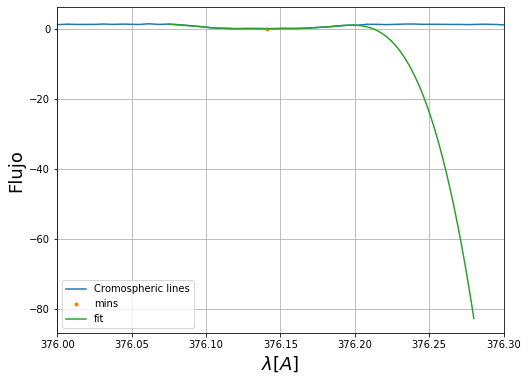

In [136]:
plt.figure(figsize = [8,6])
plt.plot(c_s['waveobs'],c_s['flux'],marker='', ls='-', label = 'Cromospheric lines')
plt.plot(lines_s['waveobs'],lines_s['flux'],marker='.', ls='', label = 'mins')
plt.plot(fit1['L'],fit1['I'],marker='', ls='-', label = 'fit')

plt.xlim(376,376.3)
#plt.ylim(-2.5, 3)
plt.grid()
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()


No handles with labels found to put in legend.


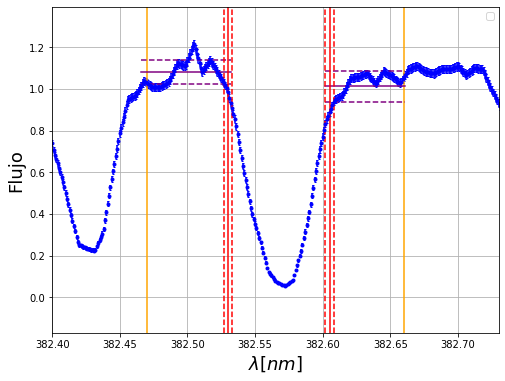

In [42]:
plt.figure(figsize = [8,6])

(_, caps, _) = plt.errorbar(c_s['waveobs'],c_s['flux'],c_s['err'], 0, color = 'blue', marker='.',ls = '',capsize=1)

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.plot(c_s['waveobs'][7590],c_s['flux'][7590], color = 'red',marker='o', ls='', label = 'mins')

plt.xlim(382.4,382.73)

plt.axvline(382.47, color = 'orange')
plt.axhline(c_s['flux'][7490:7551].mean(), color = 'purple', xmin=0.2, xmax=0.4 )
plt.axhline(c_s['flux'][7490:7551].mean() + c_s['flux'][7490:7551].std(), ls ='--', color = 'purple', xmin=0.2, xmax=0.4 )
plt.axhline(c_s['flux'][7490:7551].mean() - c_s['flux'][7490:7551].std(), ls ='--',color = 'purple', xmin=0.2, xmax=0.4 )


plt.axvline(382.53, color = 'red')
plt.axvline(382.527, color = 'red', ls='--')
plt.axvline(382.533, color = 'red', ls='--')


plt.axvline(382.66, color = 'orange')

plt.axhline(c_s['flux'][7620:7680].mean(), color = 'purple', xmin=0.61, xmax=0.79)
plt.axhline(c_s['flux'][7620:7680].mean() + c_s['flux'][7620:7680].std(), ls ='--',color = 'purple', xmin=0.61, xmax=0.79)
plt.axhline(c_s['flux'][7620:7680].mean() - c_s['flux'][7620:7680].std(), ls ='--',color = 'purple', xmin=0.61, xmax=0.79)

plt.axvline(382.605, color = 'red')
plt.axvline(382.602, color = 'red', ls='--')
plt.axvline(382.608, color = 'red', ls='--')


#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2, color = 'magenta')


#plt.ylim(-2.5, 3)
plt.grid()
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

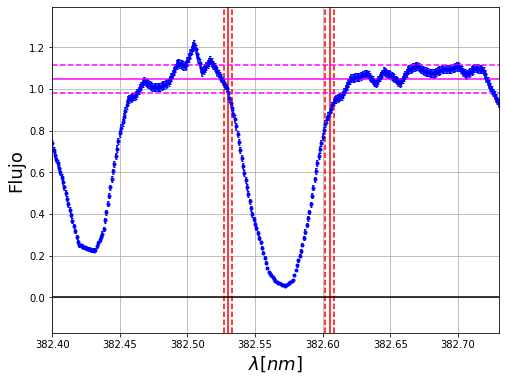

In [47]:
plt.figure(figsize = [8,6])

(_, caps, _) = plt.errorbar(c_s['waveobs'],c_s['flux'],c_s['err'], 0, color = 'blue', marker='.',ls = '',capsize=1)

for cap in caps:
    cap.set_markeredgewidth(1)
    

plt.axvline(382.53, color = 'red')
plt.axvline(382.527, color = 'red', ls='--')
plt.axvline(382.533, color = 'red', ls='--')


plt.axvline(382.605, color = 'red')
plt.axvline(382.602, color = 'red', ls='--')
plt.axvline(382.608, color = 'red', ls='--')


plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2, color = 'magenta')
plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2 + (c_s['flux'][7620:7680].std() +c_s['flux'][7490:7551].std())/2, ls='--', color = 'magenta')
plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2 - (c_s['flux'][7620:7680].std() +c_s['flux'][7490:7551].std())/2, ls='--', color = 'magenta')

plt.axhline(0, color = 'black')

#plt.ylim(-2.5, 3)
plt.xlim(382.4,382.73)
plt.grid()
#plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [73]:
c_s[7620:7680]

,waveobs,flux,err
7620,382.600,0.772007,0.015909
7621,382.601,0.802865,0.016270
7622,382.602,0.833723,0.016631
7623,382.603,0.856180,0.016891
7624,382.604,0.872799,0.017083
7625,382.605,0.889419,0.017274
7626,382.606,0.906038,0.017465
7627,382.607,0.922658,0.017656
7628,382.608,0.939277,0.017848
7629,382.609,0.949471,0.017941


In [21]:
growth_c_mine

,wave_peak,wave_base,wave_top,note,flux,loggf,lower_state_eV,upper_state_eV,EW,EWR,errEWR,error_f
0,376.117,376.050,376.183,Ti 2,-0.048152,0.180,0.574,3.869,0.096319,-3.591612,11.654456,0.000000
1,381.443,381.380,381.465,Ti 2,0.213671,-1.680,0.574,3.823,0.026619,-4.156244,25.713963,0.000000
2,388.215,388.186,388.240,Ti 2,0.576600,-1.870,1.116,4.308,0.009255,-4.622706,40.146389,0.000000
3,391.333,391.282,391.380,Ti 2,0.038103,-0.360,1.116,4.283,0.050285,-3.891109,10.328617,0.040382
4,401.222,401.179,401.261,Ti 2,0.150305,-1.780,0.574,3.663,0.034712,-4.062900,13.163558,0.041295
5,402.821,402.781,402.856,Ti 2,0.480373,-0.920,1.892,4.969,0.011283,-4.552683,56.931687,0.042208
6,416.133,416.087,416.165,Ti 2,0.590451,-2.090,1.084,4.063,0.012398,-4.525889,32.084979,0.043122
7,417.329,417.294,417.364,Ti 2,0.314776,-1.880,1.084,4.054,0.023650,-4.246649,14.895902,0.044035
8,429.982,429.936,430.056,Ti 2,0.084569,-0.460,1.180,4.063,0.047463,-3.957098,10.586451,0.044948
9,431.269,431.215,431.307,Ti 2,0.200378,-1.120,1.180,4.054,0.027935,-4.188596,15.935991,0.044752


In [99]:
growth_c_mine = growth_c_mine[~growth_c_mine.index.isin([11,17])]
growth_c_mine

,wave_peak,wave_base,wave_top,note,flux,loggf,lower_state_eV,upper_state_eV,EW,EWR,errEWR,error_f
1,376.703,376.660,376.735,Fe 1,0.109638,-0.389,1.011,4.301,0.036811,-4.010017,0.081258,0.000000
2,378.777,378.736,378.798,Fe 1,0.323211,-0.859,1.011,4.283,0.016416,-4.363116,0.309059,0.000000
3,379.485,379.449,379.512,Fe 1,0.176982,-0.761,0.990,4.256,0.025912,-4.165685,0.149208,0.040382
5,381.571,381.525,381.615,Fe 1,0.185860,0.237,1.485,4.733,0.040387,-3.975336,0.005671,0.042208
6,382.017,381.971,382.082,Fe 1,0.041227,0.119,0.859,4.103,0.054714,-3.843985,0.076407,0.043122
7,382.431,382.387,382.467,Fe 1,0.224472,-1.362,0.000,3.241,0.037944,-4.003414,0.036368,0.044035
8,382.572,382.518,382.646,Fe 1,0.056720,-0.037,0.915,4.154,0.051096,-3.874328,0.006140,0.044948
9,382.767,382.720,382.795,Fe 1,0.229226,0.062,1.557,4.796,0.034105,-4.050115,0.039026,0.044752
10,383.402,383.363,383.438,Fe 1,0.104440,-0.302,0.958,4.191,0.035719,-4.030749,0.305300,0.043198
18,388.868,388.794,388.955,Fe 1,-0.000529,-0.548,1.608,4.796,0.110252,-3.547417,0.027766,0.032621


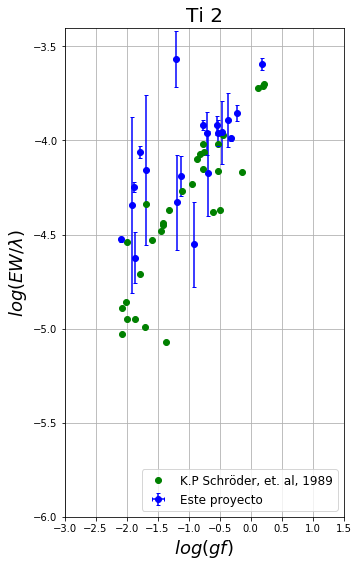

In [34]:
plt.figure(figsize = [5,9])
#plt.plot(growth_c_ispec_voigth['loggf'],growth_c_ispec_voigth['ewr'],marker='o', ls='', label = 'ispec_voigt')
#plt.plot(growth_c_ispec_gauss['loggf'],growth_c_ispec_gauss['ewr'],marker='o', ls='', label = 'ispec_gauss')
#plt.plot(,marker='o', color = 'r', ls='', label = 'Lucía')
plt.plot(data_klaus['loggf'],data_klaus['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(growth_c_mine['loggf'],growth_c_mine['EWR'],growth_c_mine['errEWR'], 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)
#plt.plot(fit1['L'],fit1['I'],marker='', ls='-', label = 'fit')
    
plt.xlim(-3,1.5)
plt.ylim(-6, -3.4)
plt.grid()
plt.legend(loc="lower right", fontsize=12)
plt.title('Ti 2',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [32]:
def Growth_theoric(gf,_lambda,E_i,T_exc):
    return gf*_lambda*np.exp(-E_i/T_exc)/(27.0)

#a = Growth_theoric(10**(growth_c_mine['loggf'][0]), growth_c_mine['wave_peak'][0], (growth_c_mine['upper_state_eV'][0] - growth_c_mine['lower_state_eV'][0] ), 5000)


theoretical_curve = []
for i in range(0,len(growth_c_mine['loggf'])):
    theoretical_curve.append(Growth_theoric(10**(growth_c_mine['loggf'][i]), growth_c_mine['wave_peak'][i], (growth_c_mine['upper_state_eV'][i] - growth_c_mine['lower_state_eV'][i] ), 5000))

    
def ajuste(a,k, x):
    return a*np.exp(- k*x)

popt1, pcov1 = scipy.optimize.curve_fit(ajuste, theoretical_curve, growth_c_mine['EWR'])

xfit = np.linspace(0,  max(theoretical_curve), 100)
yfit = ajuste(xfit,*popt1)

In [34]:
popt1

array([100.43597095, -99.56402905])

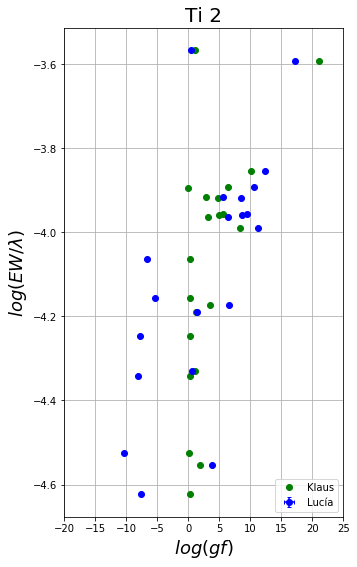

In [102]:
plt.figure(figsize = [5,9])
#plt.plot(growth_c_ispec_voigth['loggf'],growth_c_ispec_voigth['ewr'],marker='o', ls='', label = 'ispec_voigt')
#plt.plot(growth_c_ispec_gauss['loggf'],growth_c_ispec_gauss['ewr'],marker='o', ls='', label = 'ispec_gauss')
#plt.plot(,marker='o', color = 'r', ls='', label = 'Lucía')
plt.plot(theoretical_curve,growth_c_mine['EWR'],marker='o', ls='', color = 'green', label = 'Klaus')
#plt.plot(xfit,yfit,marker='', ls='--', color = 'green', label = 'Klaus')


(_, caps, _) = plt.errorbar((growth_c_mine['loggf']*(12.15))+15,growth_c_mine['EWR'],growth_c_mine['errEWR']*0.02, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Lucía')

for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.xlim(-20,25)
#plt.ylim(-6, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Ti 2',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

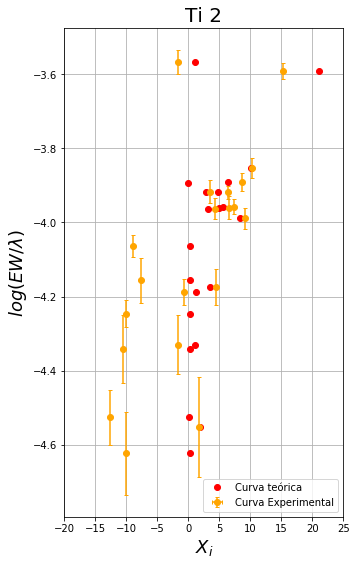

In [78]:
plt.figure(figsize = [5,9])
#plt.plot(growth_c_ispec_voigth['loggf'],growth_c_ispec_voigth['ewr'],marker='o', ls='', label = 'ispec_voigt')
#plt.plot(growth_c_ispec_gauss['loggf'],growth_c_ispec_gauss['ewr'],marker='o', ls='', label = 'ispec_gauss')
#plt.plot(,marker='o', color = 'r', ls='', label = 'Lucía')
plt.plot(theoretical_curve,growth_c_mine['EWR'],marker='o', ls='', color = 'red', label = 'Curva teórica')
#plt.plot(xfit,yfit,marker='', ls='--', color = 'green', label = 'Klaus')


(_, caps, _) = plt.errorbar((growth_c_mine['loggf']*12.3)+13,growth_c_mine['EWR'],growth_c_mine['errEWR']*0.02, 0, color = 'orange', marker='o',ls = '',capsize=2,label = 'Curva Experimental')

for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.xlim(-20,25)
#plt.ylim(-6, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Ti 2',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$X_i$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

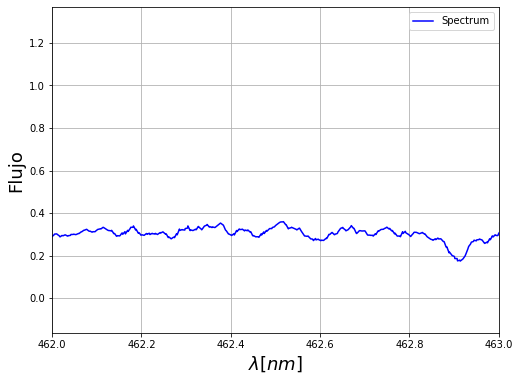

In [662]:
plt.figure(figsize = [8,6])

plt.plot(c_s['waveobs'],c_s['flux'],color = 'blue', marker='',ls = '-',label = 'Spectrum')


plt.axvline(458.31, color = 'red')
plt.axvline(458.416, color = 'red')

plt.xlim(462, 463)
plt.grid()
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [3]:
b = c_s['waveobs']>376.075
a = c_s['waveobs']<376.210
c = a&b
errorA2 = np.sqrt(np.sum(c_s['err'][c]**2))

In [4]:
errorA2

0.20710838958897468

In [26]:
1.2*(0.05/1.2)*((0.03 + 0.03)/(0.1))

0.03

In [12]:
np.sqrt(np.sum(c_s['err'][c]**2))

0.20710838958897468